<h6>Created By: Mohamed Mejri</h6>
<center>
<h1>NLP/RecEng Technical Test<br>
<b>🧸Recommendation Engine for TED Talks🧸</b>
<br></h1>
<hr>
</center>



<p>Table of Contents</p>

**This notebook is consisted of the following sctions:**


1. [Dataset Analysis](#scrollTo=GoJgA86tDuTR)
2. [Method Explanation](#scrollTo=fXkQAbWODxVH)
3. [System Description](#scrollTo=I0o1JzZJD48D)
4. [The Recommendation System](#scrollTo=s0AZVnzu-PIa)
5. [Demo](#scrollTo=JrMhsjqRtTBX)
6. [Conclusion](#scrollTo=12FMvXwP6BiJ)


<!-- * [Overview](#0)
* [Exploratory Data Analysis](#1)
* [Recommender System](#2)
    1. [Hybrid Recommendation](#3)
    2. [Deep Learning (Tensorflow)](#4) -->

# Imports and dependencies

## Downloading the dataset

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mohamed1mejri","key":"a4b673a15054defe1d4d8c707ca4f41f"}'}

In [5]:
! cp kaggle.json ~/.kaggle/

In [6]:
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets download -d miguelcorraljr/ted-ultimate-dataset

100% 199M/199M [00:29<00:00, 9.36MB/s]
100% 199M/199M [00:29<00:00, 7.02MB/s]


In [10]:
! mkdir ted

mkdir: cannot create directory ‘ted’: File exists


In [ ]:
! unzip ted-ultimate-dataset.zip -d ted

## Necessary imports

In [12]:
!pip install -U sentence-transformers --quiet

In [13]:
!pip install nltk --quiet

In [14]:
!pip install umap-learn --quiet

In [15]:
!pip install bertopic --quiet

In [16]:
!pip install googletrans==3.1.0a0 --quiet

In [17]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import torch

from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

from transformers import pipeline
from sentence_transformers import SentenceTransformer, util
from bertopic import BERTopic

import umap
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')

from wordcloud import WordCloud, STOPWORDS
import re
import string
from ast import literal_eval
from collections import Counter
from googletrans import Translator

from typing import Dict, List, Optional, Tuple
from array import array as Array

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#  Dataset Analysis

We will start first by comparing both of the datasets the **english** and the **french** versions

## Simple EDA: Comparing English and French Datasets

In [18]:
df_en = pd.read_csv("/content/ted/2020-05-01/ted_talks_en.csv")
df_fr = pd.read_csv("/content/ted/2020-05-01/ted_talks_fr.csv")

In [19]:
df_en.head()

,talk_id,title,speaker_1,all_speakers,occupations,about_speakers,views,recorded_date,published_date,event,native_lang,available_lang,comments,duration,topics,related_talks,url,description,transcript
0,1,Averting the climate crisis,Al Gore,{0: 'Al Gore'},{0: ['climate advocate']},{0: 'Nobel Laureate Al Gore focused the world’...,3523392,2006-02-25,2006-06-27,TED2006,en,"['ar', 'bg', 'cs', 'de', 'el', 'en', 'es', 'fa...",272.0,977,"['alternative energy', 'cars', 'climate change...","{243: 'New thinking on the climate crisis', 54...",https://www.ted.com/talks/al_gore_averting_the...,With the same humor and humanity he exuded in ...,"Thank you so much, Chris. And it's truly a gre..."
1,92,The best stats you've ever seen,Hans Rosling,{0: 'Hans Rosling'},{0: ['global health expert; data visionary']},"{0: 'In Hans Rosling’s hands, data sings. Glob...",14501685,2006-02-22,2006-06-27,TED2006,en,"['ar', 'az', 'bg', 'bn', 'bs', 'cs', 'da', 'de...",628.0,1190,"['Africa', 'Asia', 'Google', 'demo', 'economic...","{2056: ""Own your body's data"", 2296: 'A visual...",https://www.ted.com/talks/hans_rosling_the_bes...,You've never seen data presented like this. Wi...,"About 10 years ago, I took on the task to teac..."
2,7,Simplicity sells,David Pogue,{0: 'David Pogue'},{0: ['technology columnist']},{0: 'David Pogue is the personal technology co...,1920832,2006-02-24,2006-06-27,TED2006,en,"['ar', 'bg', 'de', 'el', 'en', 'es', 'fa', 'fr...",124.0,1286,"['computers', 'entertainment', 'interface desi...","{1725: '10 top time-saving tech tips', 2274: '...",https://www.ted.com/talks/david_pogue_simplici...,New York Times columnist David Pogue takes aim...,"(Music: ""The Sound of Silence,"" Simon & Garfun..."
3,53,Greening the ghetto,Majora Carter,{0: 'Majora Carter'},{0: ['activist for environmental justice']},{0: 'Majora Carter redefined the field of envi...,2664069,2006-02-26,2006-06-27,TED2006,en,"['ar', 'bg', 'bn', 'ca', 'cs', 'de', 'en', 'es...",219.0,1116,"['MacArthur grant', 'activism', 'business', 'c...",{1041: '3 stories of local eco-entrepreneurshi...,https://www.ted.com/talks/majora_carter_greeni...,"In an emotionally charged talk, MacArthur-winn...",If you're here today — and I'm very happy that...
4,66,Do schools kill creativity?,Sir Ken Robinson,{0: 'Sir Ken Robinson'},"{0: ['author', 'educator']}","{0: ""Creativity expert Sir Ken Robinson challe...",65051954,2006-02-25,2006-06-27,TED2006,en,"['af', 'ar', 'az', 'be', 'bg', 'bn', 'ca', 'cs...",4931.0,1164,"['children', 'creativity', 'culture', 'dance',...","{865: 'Bring on the learning revolution!', 173...",https://www.ted.com/talks/sir_ken_robinson_do_...,Sir Ken Robinson makes an entertaining and pro...,Good morning. How are you? (Audience) Good. It...


In [20]:
df_fr.head()

,talk_id,title,speaker_1,all_speakers,occupations,about_speakers,views,recorded_date,published_date,event,native_lang,available_lang,comments,duration,topics,related_talks,url,description,transcript
0,1,Al Gore explique comment limiter le réchauffem...,Al Gore,{0: 'Al Gore'},{0: ['climate advocate']},{0: 'Nobel Laureate Al Gore focused the world’...,3523390,2006-02-25,2006-06-27,TED2006,en,"['ar', 'bg', 'cs', 'de', 'el', 'en', 'es', 'fa...",272.0,977,"['alternative energy', 'cars', 'climate change...","{243: 'New thinking on the climate crisis', 54...",https://www.ted.com/talks/al_gore_averting_the...,Avec le même humour et la même simplicité qu'i...,"Merci beaucoup, Chris. C'est vraiment un honne..."
1,7,"David Pogue dit ""La simplicité vend""",David Pogue,{0: 'David Pogue'},{0: ['technology columnist']},{0: 'David Pogue is the personal technology co...,1920744,2006-02-24,2006-06-27,TED2006,en,"['ar', 'bg', 'de', 'el', 'en', 'es', 'fa', 'fr...",124.0,1286,"['computers', 'entertainment', 'interface desi...","{1725: '10 top time-saving tech tips', 2274: '...",https://www.ted.com/talks/david_pogue_simplici...,Le chroniqueur du New York Times David Pogue p...,"Bonjour répondeur, mon vieil ami. (Rires) J'ap..."
2,53,Le récit du renouveau urbain de Majora Carter,Majora Carter,{0: 'Majora Carter'},{0: ['activist for environmental justice']},{0: 'Majora Carter redefined the field of envi...,2664104,2006-02-26,2006-06-27,TED2006,en,"['ar', 'bg', 'bn', 'ca', 'cs', 'de', 'en', 'es...",219.0,1116,"['MacArthur grant', 'activism', 'business', 'c...",{1041: '3 stories of local eco-entrepreneurshi...,https://www.ted.com/talks/majora_carter_greeni...,"Dans ce témoignage émouvant, Majora Carter, mi...",Si vous êtes là aujourd'hui — et j'en suis trè...
3,66,L'école tue la créativité,Sir Ken Robinson,{0: 'Sir Ken Robinson'},"{0: ['author', 'educator']}","{0: ""Creativity expert Sir Ken Robinson challe...",65052139,2006-02-25,2006-06-27,TED2006,en,"['af', 'ar', 'az', 'be', 'bg', 'bn', 'ca', 'cs...",4931.0,1164,"['children', 'creativity', 'culture', 'dance',...","{865: 'Bring on the learning revolution!', 173...",https://www.ted.com/talks/sir_ken_robinson_do_...,Sir Ken Robinson nous expose d'une manière amu...,Bonjour. Comment ça va ? Public : Bien. Tout ç...
4,92,Les meilleures statistiques jamais vues,Hans Rosling,{0: 'Hans Rosling'},{0: ['global health expert; data visionary']},"{0: 'In Hans Rosling’s hands, data sings. Glob...",14501647,2006-02-22,2006-06-27,TED2006,en,"['ar', 'az', 'bg', 'bn', 'bs', 'cs', 'da', 'de...",628.0,1190,"['Africa', 'Asia', 'Google', 'demo', 'economic...","{2056: ""Own your body's data"", 2296: 'A visual...",https://www.ted.com/talks/hans_rosling_the_bes...,Vous n'avez jamais vu des données présentées d...,"Il y a 10 ans de cela, j'ai accepté d'enseigne..."


In [21]:
# Checking if both datasets have the same columns
if (df_en.columns == df_fr.columns).sum().any():
  print("The datasets have the same columns which are the following: \n")
  print(df_en.columns)
else:
  print("The datasets don't have the same columns")

The datasets have the same columns which are the following: 

Index(['talk_id', 'title', 'speaker_1', 'all_speakers', 'occupations',
       'about_speakers', 'views', 'recorded_date', 'published_date', 'event',
       'native_lang', 'available_lang', 'comments', 'duration', 'topics',
       'related_talks', 'url', 'description', 'transcript'],
      dtype='object')


In [22]:
print("The shape of the english dataset is: {}".format(df_en.shape))
print("While the shape of the french dataset is: {}".format(df_fr.shape))

The shape of the english dataset is: (4005, 19)
While the shape of the french dataset is: (3865, 19)


In [23]:
df_en = df_en.drop_duplicates()
df_fr = df_fr.drop_duplicates()

In [24]:
print("The shape of the english dataset is: {}".format(df_en.shape))
print("While the shape of the french dataset is: {}".format(df_fr.shape))

The shape of the english dataset is: (4005, 19)
While the shape of the french dataset is: (3865, 19)


Next we will check if the french dataset is included in the english dataset.
If so we will continue our data analysis on the english version. <br>
To do this we will check if the list of urls in the french version is included in the list of urls in the english version.

In [25]:
def is_included(a: List, b: List):
  """Checks if the list a is included in list b
  Args:
    a: List
    b: List
  Returns
    Boolean: True if the list a is included in list b and False otherwise.
  """
  a_set = set(a)
  b_set = set(b)
  return a_set.issubset(b_set)

fr_urls = list(df_fr["url"])
en_urls = list(df_en["url"])

fr_id = list(df_fr["talk_id"])
en_id = list(df_en["talk_id"])

if is_included(fr_urls, en_urls) or is_included(fr_id, en_id):
  print("The french dataset is included in the english dataset")
else: 
  print("The french dataset is NOT included in the english dataset")


The french dataset is NOT included in the english dataset


In [26]:
# Let's find the talks that are in the french version but not in the english one
url_difference = set(fr_urls).difference(set(en_urls))
id_difference = set(fr_id).difference(set(en_id))

print("There are {} extra talks in french and not in english which have the following urls: \n".format(len(id_difference)))
print(url_difference)

There are 5 extra talks in french and not in english which have the following urls: 

{'https://www.ted.com/talks/robyn_j_crook_how_do_animals_experience_pain/', 'https://www.ted.com/talks/elisabeth_pierre_l_histoire_inedite_des_femmes_a_l_origine_de_la_biere/', 'https://www.ted.com/talks/nina_klietsch_why_do_airlines_sell_too_many_tickets/', 'https://www.ted.com/talks/jennifer_lu_can_you_solve_the_counterfeit_coin_riddle/', 'https://www.ted.com/talks/marcus_bullock_an_app_that_helps_incarcerated_people_stay_connected_to_their_families/'}


In [27]:
# These are the 5 extra talks
extra_fr_df = df_fr.loc[df_fr['talk_id'].isin(id_difference)]
extra_fr_df

,talk_id,title,speaker_1,all_speakers,occupations,about_speakers,views,recorded_date,published_date,event,native_lang,available_lang,comments,duration,topics,related_talks,url,description,transcript
3191,24428,Pouvez-vous résoudre l'énigme de la fausse piè...,Jennifer Lu,{0: 'Jennifer Lu'},NaN,NaN,6218710,2017-01-03,2019-02-22,TED-Ed,en,"['ar', 'bg', 'el', 'es', 'fa', 'fr', 'he', 'hr...",NaN,254,"['creativity', 'TED-Ed', 'animation', 'math', ...","{24416: 'Can you solve the airplane riddle?', ...",https://www.ted.com/talks/jennifer_lu_can_you_...,Voir la leçon complète : http://ed.ted.com/les...,Vous êtes le meilleur mathématicien du royaume...
3208,24424,Pourquoi les compagnies aériennes vendent-elle...,Nina Klietsch,{0: 'Nina Klietsch'},NaN,NaN,2009336,2016-12-20,2019-03-01,TED-Ed,en,"['ar', 'de', 'el', 'es', 'fr', 'he', 'id', 'it...",NaN,284,"['business', 'design', 'technology', 'money', ...",{23762: 'Why do competitors open their stores ...,https://www.ted.com/talks/nina_klietsch_why_do...,Regardez la leçon complète sur ed.ted.com : ht...,Avez-vous déjà attendu des heures chez le doct...
3267,24432,Comment les animaux ressentent-ils la douleur ...,Robyn Crook,{0: 'Robyn Crook'},NaN,NaN,2787054,2017-01-17,2019-03-15,TED-Ed,en,"['ar', 'de', 'el', 'es', 'fa', 'fr', 'he', 'hi...",NaN,286,"['consciousness', 'pain', 'animals', 'science'...",{24463: 'Why do animals have such different li...,https://www.ted.com/talks/robyn_j_crook_how_do...,Leçon complète : http://ed.ted.com/lessons/how...,Les humains connaissent la piqûre surprenante ...
3604,50576,Une appli qui aide les gens en prison à mainte...,Marcus Bullock,{0: 'Marcus Bullock'},"{0: ['entrepreneur', 'justice reform advocate']}",{0: 'Marcus Bullock builds tools to help incar...,1420177,2019-06-27,2019-10-15,TED Salon The Macallan,en,"['ar', 'en', 'es', 'fr', 'hu', 'ko', 'pt', 'pt...",25.0,906,"['family', 'prison', 'social change', 'society...",{45045: 'Community-powered criminal justice re...,https://www.ted.com/talks/marcus_bullock_an_ap...,"Au cours de sa peine de huit ans de prison, Ma...","Un soir, après avoir regardé les informations ..."
3850,61551,Et si la bière était féminine ?,Elisabeth Pierre,{0: 'Elisabeth Pierre'},{0: ['zythologist']},{0: 'Elisabeth is a Zythologist'},0,2014-05-24,2020-03-28,TEDxToulouse,fr,['fr'],NaN,1135,"['history', 'women', 'innovation', 'food', 'so...","{204: 'Tales of passion', 2706: 'Why women sho...",https://www.ted.com/talks/elisabeth_pierre_l_h...,Cette présentation a été faite lors d'un événe...,C'est la première sortie de mes années collège...


In [28]:
# Let's now translate the french columns to english

translator = Translator()
extra_fr_df['description'] = extra_fr_df['description'].apply(lambda x: translator.translate(x, dest='en').text)
extra_fr_df['transcript'] = extra_fr_df['transcript'].apply(lambda x: translator.translate(x, dest='en').text)
extra_fr_df['title'] = extra_fr_df['title'].apply(lambda x: translator.translate(x, dest='en').text)

In [29]:
extra_fr_df

,talk_id,title,speaker_1,all_speakers,occupations,about_speakers,views,recorded_date,published_date,event,native_lang,available_lang,comments,duration,topics,related_talks,url,description,transcript
3191,24428,Can you solve the fake coin riddle? - Jennifer Lu,Jennifer Lu,{0: 'Jennifer Lu'},NaN,NaN,6218710,2017-01-03,2019-02-22,TED-Ed,en,"['ar', 'bg', 'el', 'es', 'fa', 'fr', 'he', 'hr...",NaN,254,"['creativity', 'TED-Ed', 'animation', 'math', ...","{24416: 'Can you solve the airplane riddle?', ...",https://www.ted.com/talks/jennifer_lu_can_you_...,See the full lesson: http://ed.ted.com/lessons...,"You are the best mathematician in the kingdom,..."
3208,24424,Why are airlines selling too many tickets? - N...,Nina Klietsch,{0: 'Nina Klietsch'},NaN,NaN,2009336,2016-12-20,2019-03-01,TED-Ed,en,"['ar', 'de', 'el', 'es', 'fr', 'he', 'id', 'it...",NaN,284,"['business', 'design', 'technology', 'money', ...",{23762: 'Why do competitors open their stores ...,https://www.ted.com/talks/nina_klietsch_why_do...,Watch the full lesson at ed.ted.com: http://ed...,Have you ever waited hours at the doctor when ...
3267,24432,How do animals feel pain? - Robyn J. Crook,Robyn Crook,{0: 'Robyn Crook'},NaN,NaN,2787054,2017-01-17,2019-03-15,TED-Ed,en,"['ar', 'de', 'el', 'es', 'fa', 'fr', 'he', 'hi...",NaN,286,"['consciousness', 'pain', 'animals', 'science'...",{24463: 'Why do animals have such different li...,https://www.ted.com/talks/robyn_j_crook_how_do...,Full lesson: http://ed.ted.com/lessons/how-do-...,"Humans know the startling sting of a needle, t..."
3604,50576,An app that helps people in prison stay connec...,Marcus Bullock,{0: 'Marcus Bullock'},"{0: ['entrepreneur', 'justice reform advocate']}",{0: 'Marcus Bullock builds tools to help incar...,1420177,2019-06-27,2019-10-15,TED Salon The Macallan,en,"['ar', 'en', 'es', 'fr', 'hu', 'ko', 'pt', 'pt...",25.0,906,"['family', 'prison', 'social change', 'society...",{45045: 'Community-powered criminal justice re...,https://www.ted.com/talks/marcus_bullock_an_ap...,"During his eight-year prison sentence, Marcus ...","One evening, after watching the evening news w..."
3850,61551,What if beer was feminine?,Elisabeth Pierre,{0: 'Elisabeth Pierre'},{0: ['zythologist']},{0: 'Elisabeth is a Zythologist'},0,2014-05-24,2020-03-28,TEDxToulouse,fr,['fr'],NaN,1135,"['history', 'women', 'innovation', 'food', 'so...","{204: 'Tales of passion', 2706: 'Why women sho...",https://www.ted.com/talks/elisabeth_pierre_l_h...,This presentation was made at a local TEDx eve...,This is the first outing of my college years. ...


Now we will add these 5 french talks to the english dataset and we will continue working on the new english dataset for now

In [30]:
df = df_en.append(extra_fr_df)

## A more in depth EDA

In [29]:
df.head()

,talk_id,title,speaker_1,all_speakers,occupations,about_speakers,views,recorded_date,published_date,event,native_lang,available_lang,comments,duration,topics,related_talks,url,description,transcript
0,1,Averting the climate crisis,Al Gore,{0: 'Al Gore'},{0: ['climate advocate']},{0: 'Nobel Laureate Al Gore focused the world’...,3523392,2006-02-25,2006-06-27,TED2006,en,"['ar', 'bg', 'cs', 'de', 'el', 'en', 'es', 'fa...",272.0,977,"['alternative energy', 'cars', 'climate change...","{243: 'New thinking on the climate crisis', 54...",https://www.ted.com/talks/al_gore_averting_the...,With the same humor and humanity he exuded in ...,"Thank you so much, Chris. And it's truly a gre..."
1,92,The best stats you've ever seen,Hans Rosling,{0: 'Hans Rosling'},{0: ['global health expert; data visionary']},"{0: 'In Hans Rosling’s hands, data sings. Glob...",14501685,2006-02-22,2006-06-27,TED2006,en,"['ar', 'az', 'bg', 'bn', 'bs', 'cs', 'da', 'de...",628.0,1190,"['Africa', 'Asia', 'Google', 'demo', 'economic...","{2056: ""Own your body's data"", 2296: 'A visual...",https://www.ted.com/talks/hans_rosling_the_bes...,You've never seen data presented like this. Wi...,"About 10 years ago, I took on the task to teac..."
2,7,Simplicity sells,David Pogue,{0: 'David Pogue'},{0: ['technology columnist']},{0: 'David Pogue is the personal technology co...,1920832,2006-02-24,2006-06-27,TED2006,en,"['ar', 'bg', 'de', 'el', 'en', 'es', 'fa', 'fr...",124.0,1286,"['computers', 'entertainment', 'interface desi...","{1725: '10 top time-saving tech tips', 2274: '...",https://www.ted.com/talks/david_pogue_simplici...,New York Times columnist David Pogue takes aim...,"(Music: ""The Sound of Silence,"" Simon & Garfun..."
3,53,Greening the ghetto,Majora Carter,{0: 'Majora Carter'},{0: ['activist for environmental justice']},{0: 'Majora Carter redefined the field of envi...,2664069,2006-02-26,2006-06-27,TED2006,en,"['ar', 'bg', 'bn', 'ca', 'cs', 'de', 'en', 'es...",219.0,1116,"['MacArthur grant', 'activism', 'business', 'c...",{1041: '3 stories of local eco-entrepreneurshi...,https://www.ted.com/talks/majora_carter_greeni...,"In an emotionally charged talk, MacArthur-winn...",If you're here today — and I'm very happy that...
4,66,Do schools kill creativity?,Sir Ken Robinson,{0: 'Sir Ken Robinson'},"{0: ['author', 'educator']}","{0: ""Creativity expert Sir Ken Robinson challe...",65051954,2006-02-25,2006-06-27,TED2006,en,"['af', 'ar', 'az', 'be', 'bg', 'bn', 'ca', 'cs...",4931.0,1164,"['children', 'creativity', 'culture', 'dance',...","{865: 'Bring on the learning revolution!', 173...",https://www.ted.com/talks/sir_ken_robinson_do_...,Sir Ken Robinson makes an entertaining and pro...,Good morning. How are you? (Audience) Good. It...


In [30]:
df.tail()

,talk_id,title,speaker_1,all_speakers,occupations,about_speakers,views,recorded_date,published_date,event,native_lang,available_lang,comments,duration,topics,related_talks,url,description,transcript
3191,24428,Can you solve the fake coin riddle? - Jennifer Lu,Jennifer Lu,{0: 'Jennifer Lu'},NaN,NaN,6218710,2017-01-03,2019-02-22,TED-Ed,en,"['ar', 'bg', 'el', 'es', 'fa', 'fr', 'he', 'hr...",NaN,254,"['creativity', 'TED-Ed', 'animation', 'math', ...","{24416: 'Can you solve the airplane riddle?', ...",https://www.ted.com/talks/jennifer_lu_can_you_...,See the full lesson: http://ed.ted.com/lessons...,"You are the best mathematician in the kingdom,..."
3208,24424,Why are airlines selling too many tickets? - N...,Nina Klietsch,{0: 'Nina Klietsch'},NaN,NaN,2009336,2016-12-20,2019-03-01,TED-Ed,en,"['ar', 'de', 'el', 'es', 'fr', 'he', 'id', 'it...",NaN,284,"['business', 'design', 'technology', 'money', ...",{23762: 'Why do competitors open their stores ...,https://www.ted.com/talks/nina_klietsch_why_do...,Watch the full lesson at ed.ted.com: http://ed...,Have you ever waited hours at the doctor when ...
3267,24432,How do animals feel pain? - Robyn J. Crook,Robyn Crook,{0: 'Robyn Crook'},NaN,NaN,2787054,2017-01-17,2019-03-15,TED-Ed,en,"['ar', 'de', 'el', 'es', 'fa', 'fr', 'he', 'hi...",NaN,286,"['consciousness', 'pain', 'animals', 'science'...",{24463: 'Why do animals have such different li...,https://www.ted.com/talks/robyn_j_crook_how_do...,Full lesson: http://ed.ted.com/lessons/how-do-...,"Humans know the startling sting of a needle, t..."
3604,50576,An app that helps people in prison stay connec...,Marcus Bullock,{0: 'Marcus Bullock'},"{0: ['entrepreneur', 'justice reform advocate']}",{0: 'Marcus Bullock builds tools to help incar...,1420177,2019-06-27,2019-10-15,TED Salon The Macallan,en,"['ar', 'en', 'es', 'fr', 'hu', 'ko', 'pt', 'pt...",25.0,906,"['family', 'prison', 'social change', 'society...",{45045: 'Community-powered criminal justice re...,https://www.ted.com/talks/marcus_bullock_an_ap...,"During his eight-year prison sentence, Marcus ...","One evening, after watching the evening news w..."
3850,61551,What if beer was feminine?,Elisabeth Pierre,{0: 'Elisabeth Pierre'},{0: ['zythologist']},{0: 'Elisabeth is a Zythologist'},0,2014-05-24,2020-03-28,TEDxToulouse,fr,['fr'],NaN,1135,"['history', 'women', 'innovation', 'food', 'so...","{204: 'Tales of passion', 2706: 'Why women sho...",https://www.ted.com/talks/elisabeth_pierre_l_h...,This presentation was made at a local TEDx eve...,This is the first outing of my college years. ...


In [31]:
print("The shape of our new dataset is: {}".format(df.shape))

The shape of our new dataset is: (4010, 19)


In [32]:
# check the different data types in our data
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4010 entries, 0 to 3850
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   talk_id         4010 non-null   int64  
 1   title           4010 non-null   object 
 2   speaker_1       4010 non-null   object 
 3   all_speakers    4006 non-null   object 
 4   occupations     3485 non-null   object 
 5   about_speakers  3504 non-null   object 
 6   views           4010 non-null   int64  
 7   recorded_date   4009 non-null   object 
 8   published_date  4010 non-null   object 
 9   event           4010 non-null   object 
 10  native_lang     4010 non-null   object 
 11  available_lang  4010 non-null   object 
 12  comments        3351 non-null   float64
 13  duration        4010 non-null   int64  
 14  topics          4010 non-null   object 
 15  related_talks   4010 non-null   object 
 16  url             4010 non-null   object 
 17  description     4010 non-null   o

In [33]:
# check if there is any missing values
df.isnull().sum()

talk_id             0
title               0
speaker_1           0
all_speakers        4
occupations       525
about_speakers    506
views               0
recorded_date       1
published_date      0
event               0
native_lang         0
available_lang      0
comments          659
duration            0
topics              0
related_talks       0
url                 0
description         0
transcript          0
dtype: int64

As shown above, we have 1 numeric feature, 3 integers and the rest(15) categorical features. We also have some null values that we will need to handle later on.

In [34]:
df.describe()

,talk_id,views,comments,duration
count,4010.000000,4.010000e+03,3351.000000,4010.000000
mean,12463.273566,2.148428e+06,161.956132,723.822943
std,17467.389518,3.449873e+06,268.809212,361.828499
min,1.000000,0.000000e+00,0.000000,60.000000
25%,1253.500000,8.821292e+05,38.000000,392.000000
50%,2335.500000,1.375786e+06,89.000000,738.000000
75%,23785.750000,2.133304e+06,188.000000,973.750000
max,62794.000000,6.505195e+07,6449.000000,3922.000000


**Observations**: <br>
There are some high standard deviation especially seen in the comments and the views

### Comments

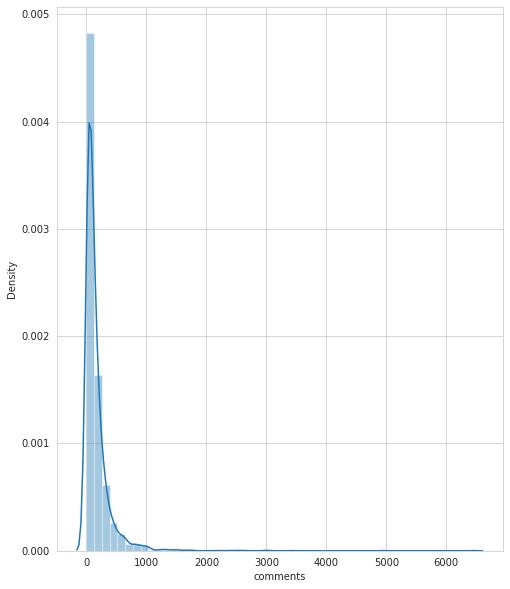

In [35]:
plt.figure(figsize=(8,10))
sns.set_style("whitegrid")
sns.distplot(df['comments'])
plt.show()

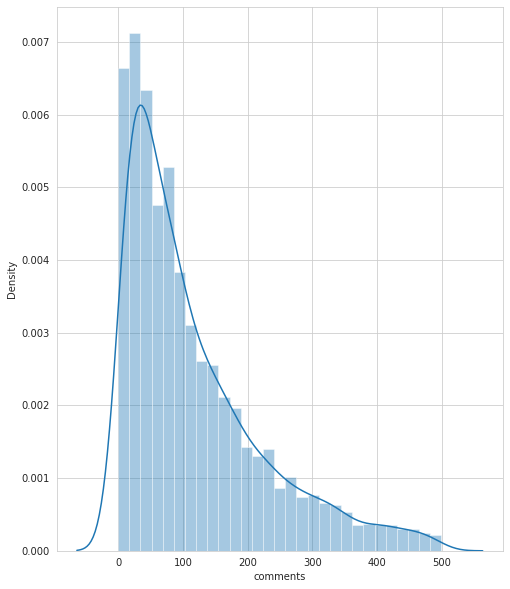

In [36]:
plt.figure(figsize=(8,10))
sns.distplot(df[df['comments'] < 500]['comments'])
plt.show()

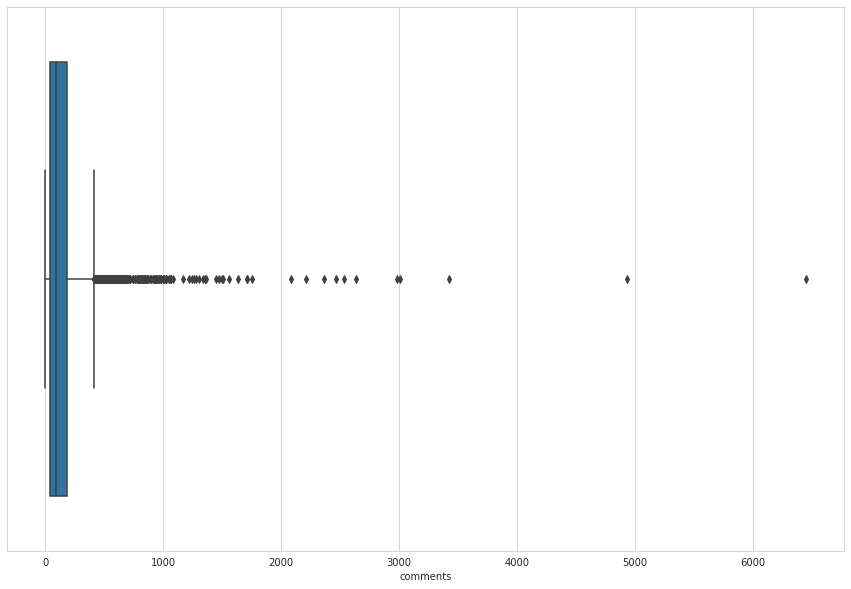

In [37]:
plt.figure(figsize=(15,10))
sns.boxplot(x="comments", data=df)
plt.show()

It is clear that we do have some outliers here. However it is interesting to see what are these ted talks that have such a huge ammount of comments. It reflects that topics are controversial

In [38]:
most_commented_talks = df[['title', 'speaker_1', 'occupations', 'views', 'topics', 'comments']].sort_values('comments', ascending=False)[:20]
most_commented_talks

,title,speaker_1,occupations,views,topics,comments
94,Militant atheism,Richard Dawkins,{0: ['evolutionary biologist']},5788514,"['God', 'atheism', 'culture', 'religion', 'sci...",6449.0
4,Do schools kill creativity?,Sir Ken Robinson,"{0: ['author', 'educator']}",65051954,"['children', 'creativity', 'culture', 'dance',...",4931.0
617,Science can answer moral questions,Sam Harris,"{0: ['neuroscientist', 'philosopher']}",6331825,"['culture', 'global issues', 'morality', 'phil...",3424.0
1735,How do you explain consciousness?,David Chalmers,{0: ['philosopher']},2910843,"['brain', 'consciousness', 'neuroscience', 'ph...",3006.0
197,My stroke of insight,Jill Bolte Taylor,{0: ['neuroanatomist']},26553231,"['biology', 'brain', 'consciousness', 'global ...",2984.0
1296,Your body language may shape who you are,Amy Cuddy,{0: ['social psychologist']},57074270,"['body language', 'brain', 'business', 'psycho...",2633.0
911,Taking imagination seriously,Janet Echelman,{0: ['artist']},2297341,"['art', 'cities', 'culture', 'data', 'design',...",2529.0
799,On reading the Koran,Lesley Hazleton,"{0: ['writer', 'psychologist']}",2269271,"['TEDx', 'culture', 'global issues', 'journali...",2463.0
631,The danger of science denial,Michael Specter,{0: ['writer']},2170700,"['global issues', 'medicine', 'religion', 'sci...",2366.0
796,The power of vulnerability,Brené Brown,{0: ['vulnerability researcher']},47544833,"['TEDx', 'communication', 'culture', 'depressi...",2209.0


As expected the most commented ted talks are the ones that have some controversial topics such as: <br> 
Religion, culture, children, consciousness, ...
<br>
One other thing to mention is that the talk that has the most comments is not the most viewed one. So it would be also interesting to see the correlation between the views and the comments
<!-- ```
Religion, culture, children, consciousness, ...
``` -->



In [39]:
df[['views', 'comments']].corr()

,views,comments
views,1.000000,0.500758
comments,0.500758,1.000000


As shown in the correlation matrix we have a **moderate** correlation between the views and the comments 

Now let's really see the most repetitive topics in the top 20 most commented talks

In [40]:
def flatten(l: List):
  """A function that returns a flattens a list
    Args: 
      l: a list of lists
    Returns:
      A flattened list"""
  return [item for sublist in l for item in sublist]

def get_topics_list(df):
  """Returns the list of all topics in a dataframe df"""
  return flatten(df["topics"].apply(lambda x: eval(x)))


In [41]:
most_commented_topics = get_topics_list(most_commented_talks)

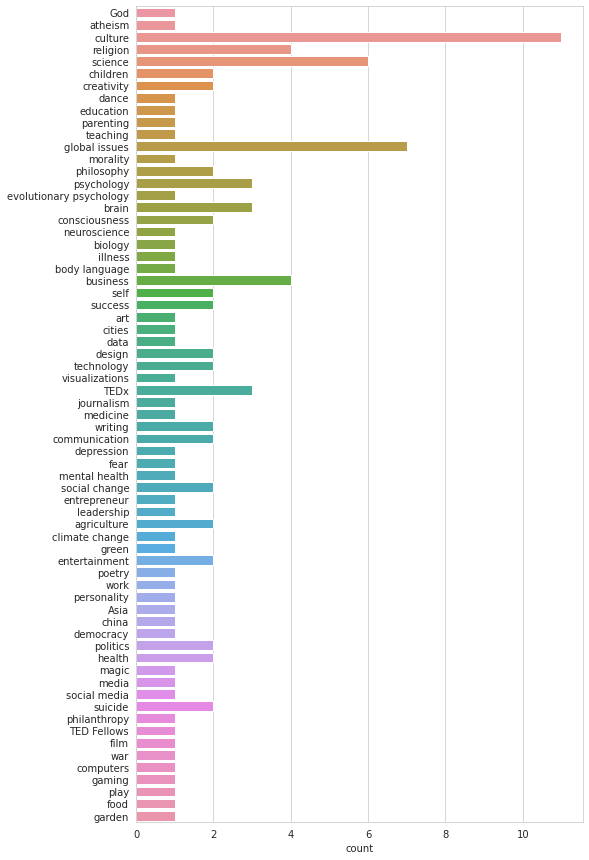

In [42]:
plt.figure(figsize=(8,15))
sns.countplot(y=most_commented_topics, )
plt.show()

In the top 20 commented talks. The top 5 topics that were discussed are: <br>


1.   Culture
2.   Global issues
3.   Science
4.   Religion and Business (tied at 4th place)

### Views

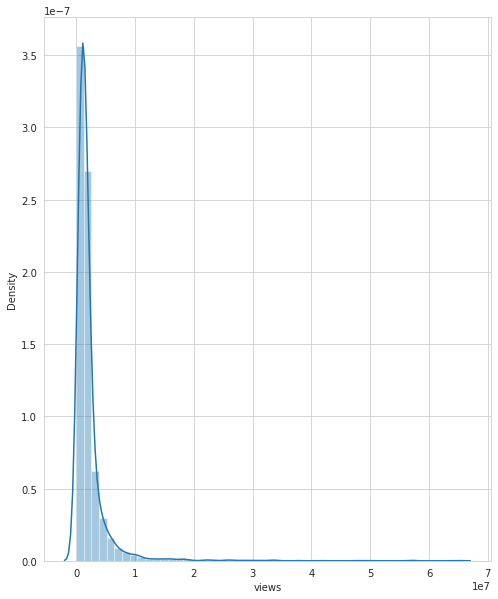

In [43]:
plt.figure(figsize=(8,10))
sns.distplot(df['views'])
plt.show()

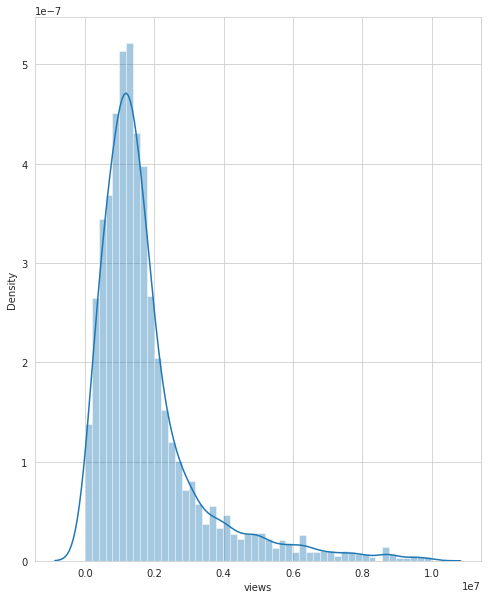

In [44]:
plt.figure(figsize=(8,10))
sns.distplot(df[df['views'] < 1e7]['views'])
plt.show()

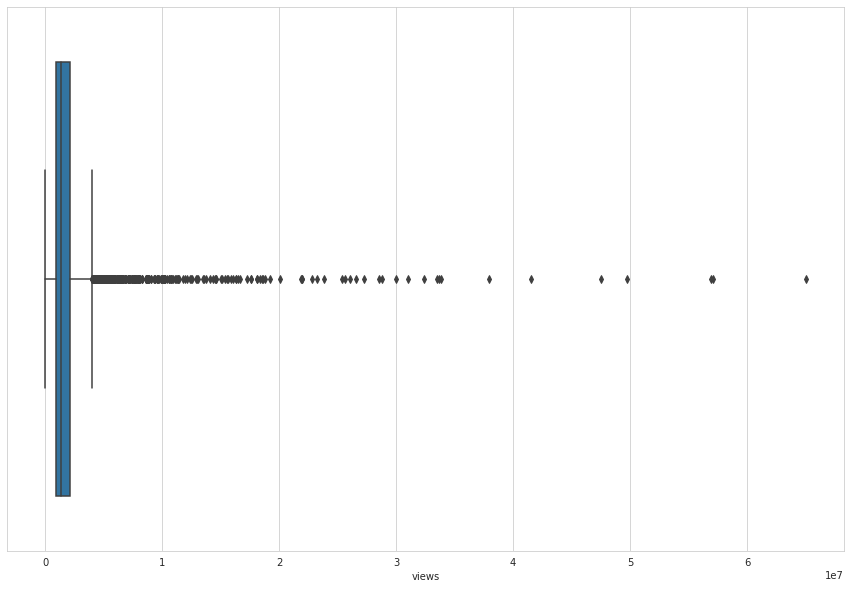

In [45]:
plt.figure(figsize=(15,10))
sns.boxplot(x="views", data=df)
plt.show()

Again we have some outliers like we've seen while exploring the comments.<br>
Let us now see what are the most popular talks

In [46]:
# Most viewed talks
pop_talks = df[['title', 'speaker_1', 'occupations', 'views', 'topics']].sort_values('views', ascending=False)[:20]
pop_talks

,title,speaker_1,occupations,views,topics
4,Do schools kill creativity?,Sir Ken Robinson,"{0: ['author', 'educator']}",65051954,"['children', 'creativity', 'culture', 'dance',..."
1296,Your body language may shape who you are,Amy Cuddy,{0: ['social psychologist']},57074270,"['body language', 'brain', 'business', 'psycho..."
2062,This is what happens when you reply to spam email,James Veitch,{0: ['comedian and writer']},56932551,"['comedy', 'curiosity', 'communication', 'humo..."
646,How great leaders inspire action,Simon Sinek,{0: ['leadership expert']},49730580,"['TEDx', 'business', 'entrepreneur', 'leadersh..."
796,The power of vulnerability,Brené Brown,{0: ['vulnerability researcher']},47544833,"['TEDx', 'communication', 'culture', 'depressi..."
1724,How to speak so that people want to listen,Julian Treasure,{0: ['sound consultant']},41504331,"['culture', 'sound', 'speech']"
2108,Inside the mind of a master procrastinator,Tim Urban,{0: ['blogger']},37976820,"['brain', 'comedy', 'decision-making', 'entert..."
1366,"Looks aren't everything. Believe me, I'm a model.",Cameron Russell,{0: ['model']},33874546,"['TEDx', 'beauty', 'culture', 'fashion', 'phot..."
2724,My philosophy for a happy life,Sam Berns,{0: ['activist']},33691484,"['life', 'happiness', 'personal growth', 'self..."
1898,The next outbreak? We're not ready,Bill Gates,{0: ['philanthropist']},33521780,"['disaster relief', 'disease', 'ebola', 'globa..."


In [47]:
pop_topics = get_topics_list(pop_talks)

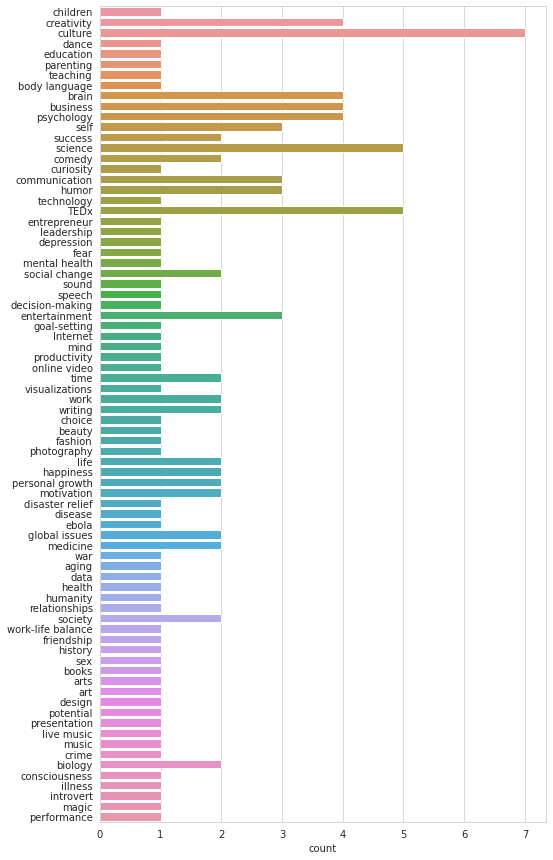

In [48]:
plt.figure(figsize=(8,15))
sns.countplot(y=pop_topics)
plt.show()

In the top 20 most viewed talks. The top 5 topics that were discussed are: <br>


1.Culture<br>
2.Tie: Science & TEDx (here TEDx can refer to local issues)<br>
4.Tie: Creativity, brain, business and psychology<br>

### Speakers

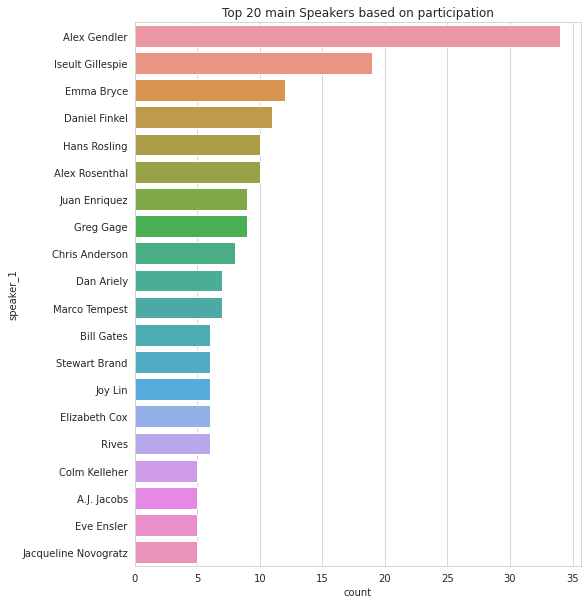

In [49]:
# Speakers
plt.figure(figsize=(8,10))
sns.countplot(data=df, y="speaker_1", order = df['speaker_1'].value_counts().iloc[:20].index)
plt.title("Top 20 main Speakers based on participation")
plt.show()

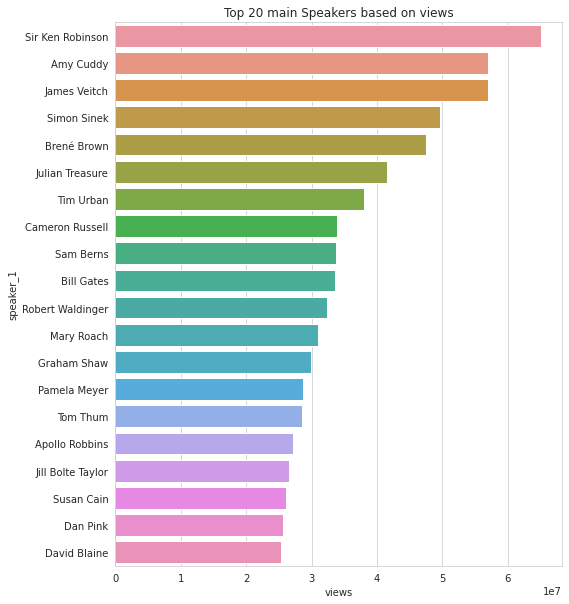

In [50]:
plt.figure(figsize=(8,10))
sns.barplot(x='views', y='speaker_1', data=pop_talks)
plt.title("Top 20 main Speakers based on views")
plt.show()

### Topics

In [51]:
topics = get_topics_list(df)
topics_counter = Counter(topics)
print("There are {} topics in the dataset".format(len(topics_counter)))
print("These are the top 20 topics: \n {}".format(topics_counter.most_common()[:20]))

There are 457 topics in the dataset
These are the top 20 topics: 
 [('science', 994), ('technology', 980), ('culture', 680), ('TEDx', 581), ('global issues', 574), ('TED-Ed', 566), ('society', 559), ('design', 519), ('social change', 513), ('animation', 490), ('business', 444), ('health', 442), ('history', 407), ('education', 390), ('humanity', 388), ('innovation', 372), ('biology', 355), ('entertainment', 348), ('future', 329), ('art', 328)]


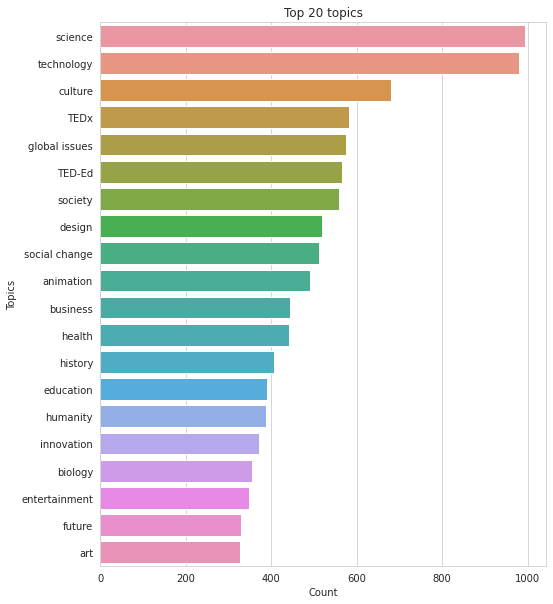

In [52]:
topics_df = pd.DataFrame(list(topics_counter.items()))
topics_df = topics_df.rename(columns={0:'Topics', 1:'Count'})
topics_df = topics_df.sort_values(['Count'], ascending=False).reset_index(drop=True)
plt.figure(figsize=(8,10))
sns.barplot(x='Count', y='Topics', data=topics_df.iloc[:20])
plt.title("Top 20 topics")
plt.show()

### Analysing the text features

In [53]:
df.head()

,talk_id,title,speaker_1,all_speakers,occupations,about_speakers,views,recorded_date,published_date,event,native_lang,available_lang,comments,duration,topics,related_talks,url,description,transcript
0,1,Averting the climate crisis,Al Gore,{0: 'Al Gore'},{0: ['climate advocate']},{0: 'Nobel Laureate Al Gore focused the world’...,3523392,2006-02-25,2006-06-27,TED2006,en,"['ar', 'bg', 'cs', 'de', 'el', 'en', 'es', 'fa...",272.0,977,"['alternative energy', 'cars', 'climate change...","{243: 'New thinking on the climate crisis', 54...",https://www.ted.com/talks/al_gore_averting_the...,With the same humor and humanity he exuded in ...,"Thank you so much, Chris. And it's truly a gre..."
1,92,The best stats you've ever seen,Hans Rosling,{0: 'Hans Rosling'},{0: ['global health expert; data visionary']},"{0: 'In Hans Rosling’s hands, data sings. Glob...",14501685,2006-02-22,2006-06-27,TED2006,en,"['ar', 'az', 'bg', 'bn', 'bs', 'cs', 'da', 'de...",628.0,1190,"['Africa', 'Asia', 'Google', 'demo', 'economic...","{2056: ""Own your body's data"", 2296: 'A visual...",https://www.ted.com/talks/hans_rosling_the_bes...,You've never seen data presented like this. Wi...,"About 10 years ago, I took on the task to teac..."
2,7,Simplicity sells,David Pogue,{0: 'David Pogue'},{0: ['technology columnist']},{0: 'David Pogue is the personal technology co...,1920832,2006-02-24,2006-06-27,TED2006,en,"['ar', 'bg', 'de', 'el', 'en', 'es', 'fa', 'fr...",124.0,1286,"['computers', 'entertainment', 'interface desi...","{1725: '10 top time-saving tech tips', 2274: '...",https://www.ted.com/talks/david_pogue_simplici...,New York Times columnist David Pogue takes aim...,"(Music: ""The Sound of Silence,"" Simon & Garfun..."
3,53,Greening the ghetto,Majora Carter,{0: 'Majora Carter'},{0: ['activist for environmental justice']},{0: 'Majora Carter redefined the field of envi...,2664069,2006-02-26,2006-06-27,TED2006,en,"['ar', 'bg', 'bn', 'ca', 'cs', 'de', 'en', 'es...",219.0,1116,"['MacArthur grant', 'activism', 'business', 'c...",{1041: '3 stories of local eco-entrepreneurshi...,https://www.ted.com/talks/majora_carter_greeni...,"In an emotionally charged talk, MacArthur-winn...",If you're here today — and I'm very happy that...
4,66,Do schools kill creativity?,Sir Ken Robinson,{0: 'Sir Ken Robinson'},"{0: ['author', 'educator']}","{0: ""Creativity expert Sir Ken Robinson challe...",65051954,2006-02-25,2006-06-27,TED2006,en,"['af', 'ar', 'az', 'be', 'bg', 'bn', 'ca', 'cs...",4931.0,1164,"['children', 'creativity', 'culture', 'dance',...","{865: 'Bring on the learning revolution!', 173...",https://www.ted.com/talks/sir_ken_robinson_do_...,Sir Ken Robinson makes an entertaining and pro...,Good morning. How are you? (Audience) Good. It...


Let's see what the transcription's word cloud looks like

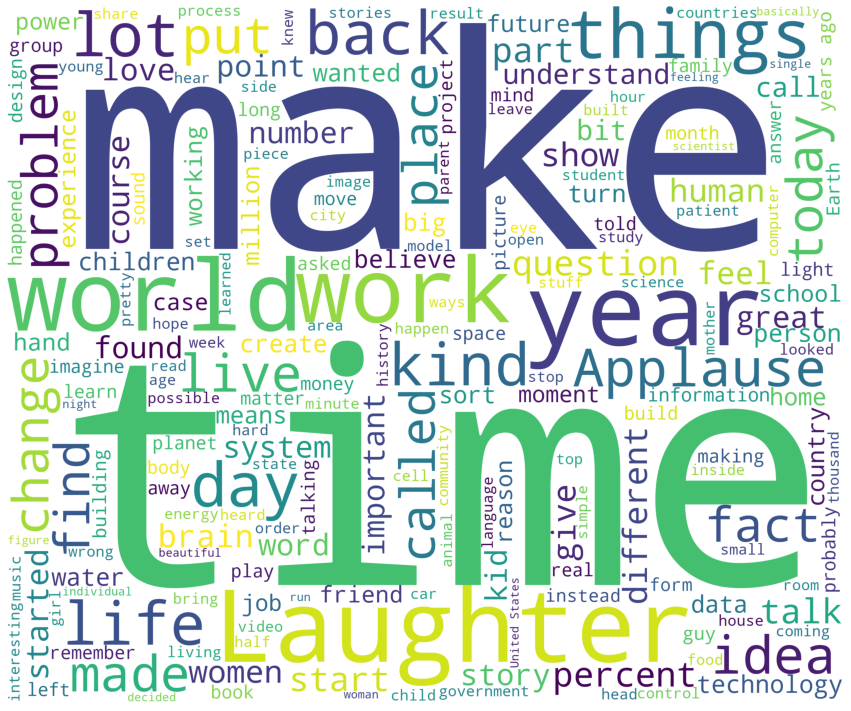

In [54]:
corpus = ' '.join(df['transcript'])
corpus = corpus.replace('.', '. ')

wordcloud = WordCloud(stopwords=stopwords.words(), background_color='white',width=2400,height=2000).generate(corpus)
plt.figure(figsize=(15,15))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

As you can see the most frequent words are: time, make, laughter, world, work, ...

Now let's do the same for the descriptions

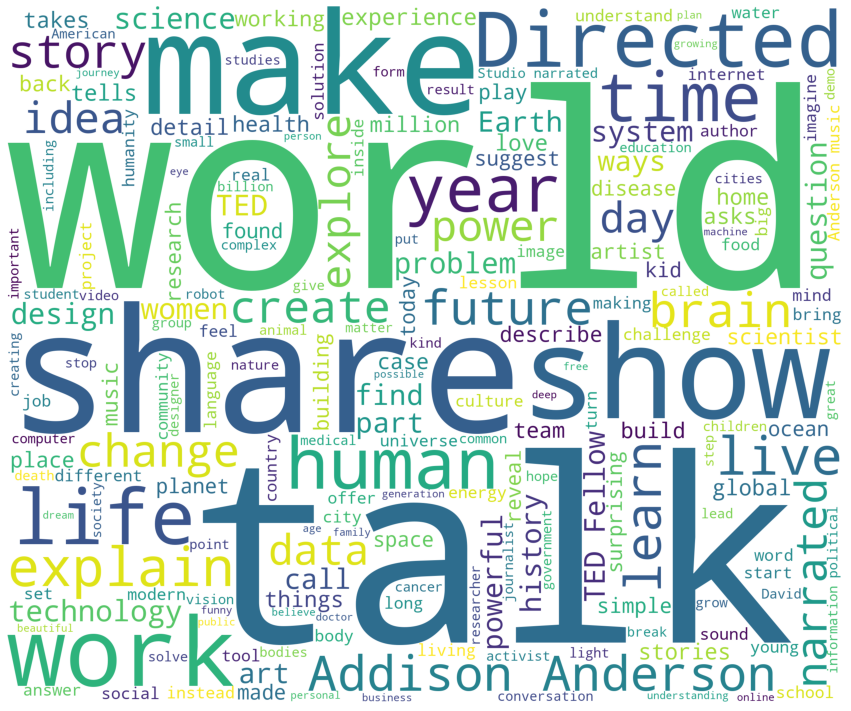

In [55]:
desc_corpus = ' '.join(df['description'])
desc_corpus = desc_corpus.replace('.', '. ')

wordcloud = WordCloud(stopwords=stopwords.words(), background_color='white',width=2400,height=2000).generate(desc_corpus)
plt.figure(figsize=(15,15))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

The most frequent words are: talk, world, make, share, show, work, ...

Let's try to encode the descriptions of the talks using a sentence transformer and see if the embeddings produced will give us any valuable info

In [56]:
# Here we want to get the most popular topic from the list of topics of each talk, to use them later for visualization

def most_pop_topics(df, topics_counter):
  """Returns a list in which the index refers to the talk and the element refer to only one topic
      which was selected based on popularity.
    Args:
      df: DataFrame
      topics_counter: Counter on the topics
    Returns:
      topics: list
    """
  topics = []
  for t_list in df['topics']:
    for topic_count in topics_counter.most_common():
      if topic_count[0] in literal_eval(t_list):
        topics.append(topic_count[0])
        break
  return topics

topics = most_pop_topics(df, topics_counter)
print(len(topics))

4010


In [57]:
# Let's create a whole new column with filtered description(description without stopwords)
stop_words = set(stopwords.words('english'))

df['description_without_stopwords'] = df['description'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [58]:
# Here we use produce the embeddings with a pretrained from sentence-transformers

sentences = list(df["description_without_stopwords"])

# model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
model = SentenceTransformer('sentence-transformers/msmarco-distilbert-base-v4')
descr_embeddings = model.encode(sentences)

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.71k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/545 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/265M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/319 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

In [59]:
# Now we will apply tsne on the generated embeddings
tsne_embeddings = TSNE(n_components=3, learning_rate='auto', init='pca', perplexity=30).fit_transform(descr_embeddings)

In [60]:
# 3D plots of the tsne output
fig = px.scatter_3d(x=tsne_embeddings[:, 0], y=tsne_embeddings[:, 1], z=tsne_embeddings[:, 2],
              color=topics)
fig.show()

In [61]:
# 2D plots of the tsne output
fig = px.scatter(x=tsne_embeddings[:, 0], y=tsne_embeddings[:, 1],
              color=topics)
fig.show()

In [62]:
reducer = umap.UMAP(n_components=3)
umap_embedding = reducer.fit_transform(descr_embeddings)
umap_embedding.shape

(4010, 3)

In [63]:
# 3D plots of the umap output
fig = px.scatter_3d(x=umap_embedding[:, 0], y=umap_embedding[:, 1], z=umap_embedding[:, 2],
              color=topics)
fig.show()

In [64]:
# 2D plots of the umap output
fig = px.scatter(x=umap_embedding[:, 0], y=umap_embedding[:, 1],
              color=topics)
fig.show()

Unfortunately, we cannot observe the patterns clearly in 2D nor in 3D.
We need to explore new methods other than tsne and umap.

In [65]:
# Let's try BERTopic with all-MiniLM-L6-v2 as embedding model
topic_model = BERTopic(embedding_model="all-MiniLM-L6-v2").fit(list(df["description_without_stopwords"]))


Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

In [66]:
topic_model.get_topic_info().head(5)

,Topic,Count,Name
0,-1,1528,-1_in_talk_us_world
1,0,178,0_universe_space_earth_life
2,1,148,1_music_performance_dance_sound
3,2,119,2_ocean_sea_fish_marine
4,3,113,3_brain_brains_neuroscientist_memory


In [67]:
topic_model.visualize_topics()

In [68]:
topic_model.visualize_barchart()

-----------------


-------------

# Method Explanation

Since we don't have users' data we cannot perform the traditional approach for recommendation systems such as Collaborative Filtering and Content-Based Filtering.

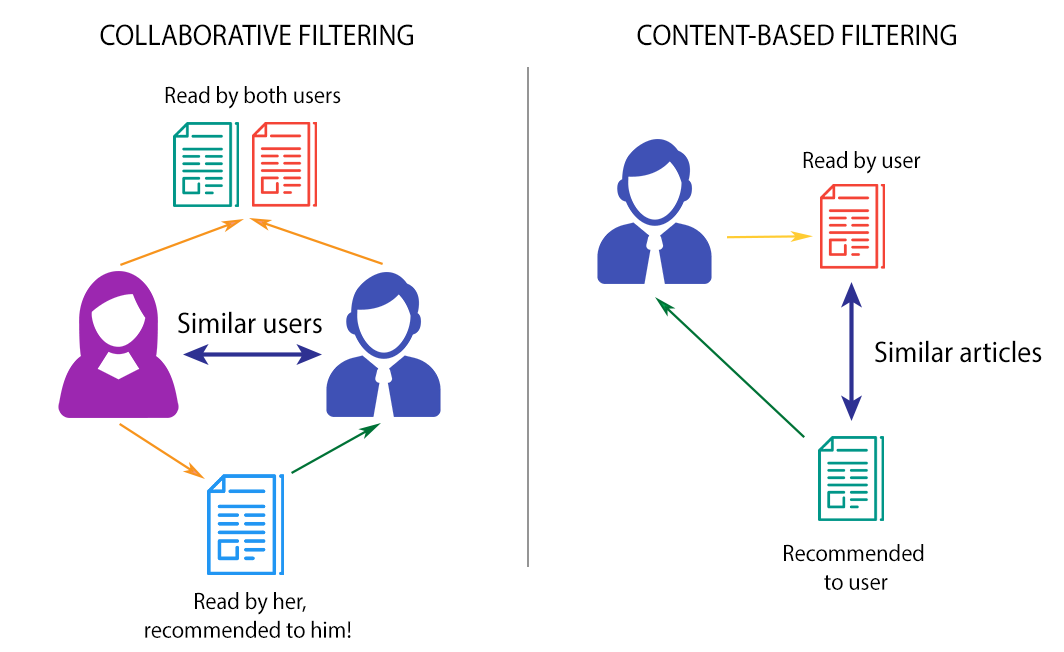

In addition, the nature of the problem and data are more suitable for a Search Engine. </br>
That's why our approach is based on [Semantic Search](https://https://www.sbert.net/examples/applications/semantic-search/README.html). </br>
</br>

---

While building this Search/Recommendation Engine we first used [`googletrans`](https://https://py-googletrans.readthedocs.io/en/latest/) in order to access the Google Translate API which help us translate and detect languages. Then we translated the 5 talks that were in the french dataset but not in the english dataset and we added them to the final dataset that we will work on. 

We chose to work on the english dataset for multiple reasons:


1.   It has more Ted Talks.
2.   The majority of models in NLP work on english and they tend to achieve better performance than other models.

Of course if the query was in french it will be translated but the output of the system will still be in french and this is done by retrieving the `talk_id` and returning the talk in the french dataset with that specific `talk_id` if it exists. If not then it we will return it from the final dataset after translating it to french.
</br></br>
Next we used [`shoubhikc/negation_bert`](https://huggingface.co/shoubhikc/negation_bert) a pretrained model from [Hugging Face](https://huggingface.co). While the repo does not cite or reference the dataset/base model's architecture but it is more likely to be a simpler and less complex implementation of the `NegBert` that was mentioned in [Khandelwal, A., & Sawant, S.. (2019). NegBERT: A Transfer Learning Approach for Negation Detection and Scope Resolution](https://arxiv.org/abs/1911.04211). We say simpler because of the fact that it cannot detect all the negation cues such as affixes but it can still detect the `n't` and single word cues such as `not, no, etc.` which is useful in our case.

The **Negation Bert** with its capabilites in negation detection, helped us to tackle the problems that this kind of queries "*A talk not about climate change*" presents. The exact way of handling these queries will be discussed in the [System Description section](#scrollTo=I0o1JzZJD48D)
</br></br>
In addition to that, we used [Sentence Transformers](https://www.sbert.net/index.html) which is a Python framework for state-of-the-art sentence, text and image embeddings. 
Our logic is that we will use a sentence transformer or multiple sentence transformers in our case to embed the titles, descriptions and transcriptions into **3 different vector spaces**. After that and at search time, the query will be embedded into the same vector spaces. The closer the query is to a specific vector the higher the semantic overlap between them.

An example of the sentence transformers' architecture is presented in 
[Reimers, N., & Gurevych, I.. Sentence-BERT: Sentence Embeddings using Siamese BERT-Networks.](https://arxiv.org/abs/1908.10084)
Where they added a pooling operation to the output of BERT in a Siamese Bert Network with a Softmax classifier on top. 
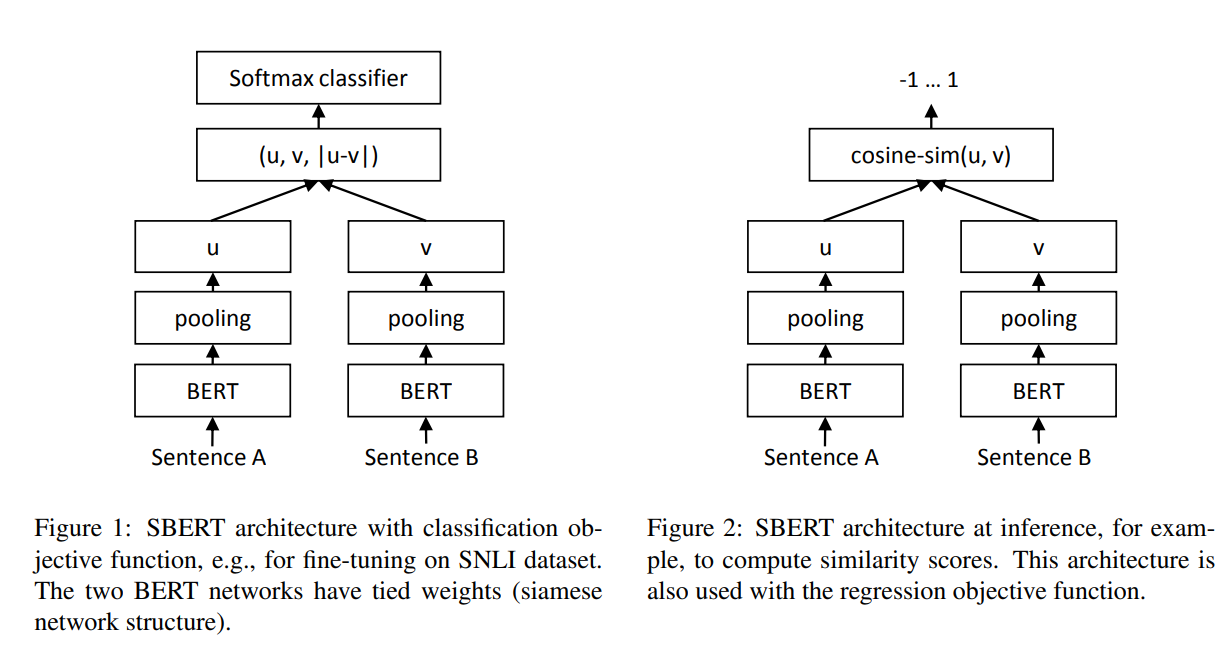

 

In our case, we used both **Symmetric** and **Asymmetric** Semantic Search:
* The Symmetric Semantic Search is used when the query and the entries in the corpus are of about the same length and have the same amount of content. "*For symmetric tasks, you could potentially flip the query and the entries in your corpus*." [Reference](https://www.sbert.net/examples/applications/semantic-search/README.html#symmetric-vs-asymmetric-semantic-search)</br>
This actually the case for the titles of the Talks. That's why we used it on the titles.

* The Asymmetric Semantic Search is used when the **query is short** and the corpus is consisted of longer paragraphs. "*For asymmetric tasks, flipping the query and the entries in your corpus usually does not make sense.*" [Same Reference](https://www.sbert.net/examples/applications/semantic-search/README.html#symmetric-vs-asymmetric-semantic-search)</br>
This is the case for the descriptions and transcriptions.

The models that we chose were: `all-MiniLM-L6-v2` with cosine-similarity for the Symmetric Semantic Search  and the `msmarco-distilbert-base-dot-prod-v3` with dot-product for the Asymmetric Semantic Search.

The difference in the choice of cosine-similarity vs dot-product is backed by the fact that "*Models tuned for cosine-similarity will prefer the retrieval of shorter passages, while models for dot-product will prefer the retrieval of longer passages.*" [Reference](https://www.sbert.net/docs/pretrained-models/msmarco-v3.html).
</br></br>
The next thing we did is to build a scoring function along with other useful functions (details in [System Description section](#scrollTo=I0o1JzZJD48D)) which helped us to calculate a score based the cosine cosine-similarity and dot-products scaled output, the negations in the query and the popularity of the talks. These scores will be attributed to all the talks in the dataset and the talk with the highest score will be more likely to satisfy the query

# System Description

For better understanding how our system works, we will describe it in 3 steps

The following figure illustrates the first step

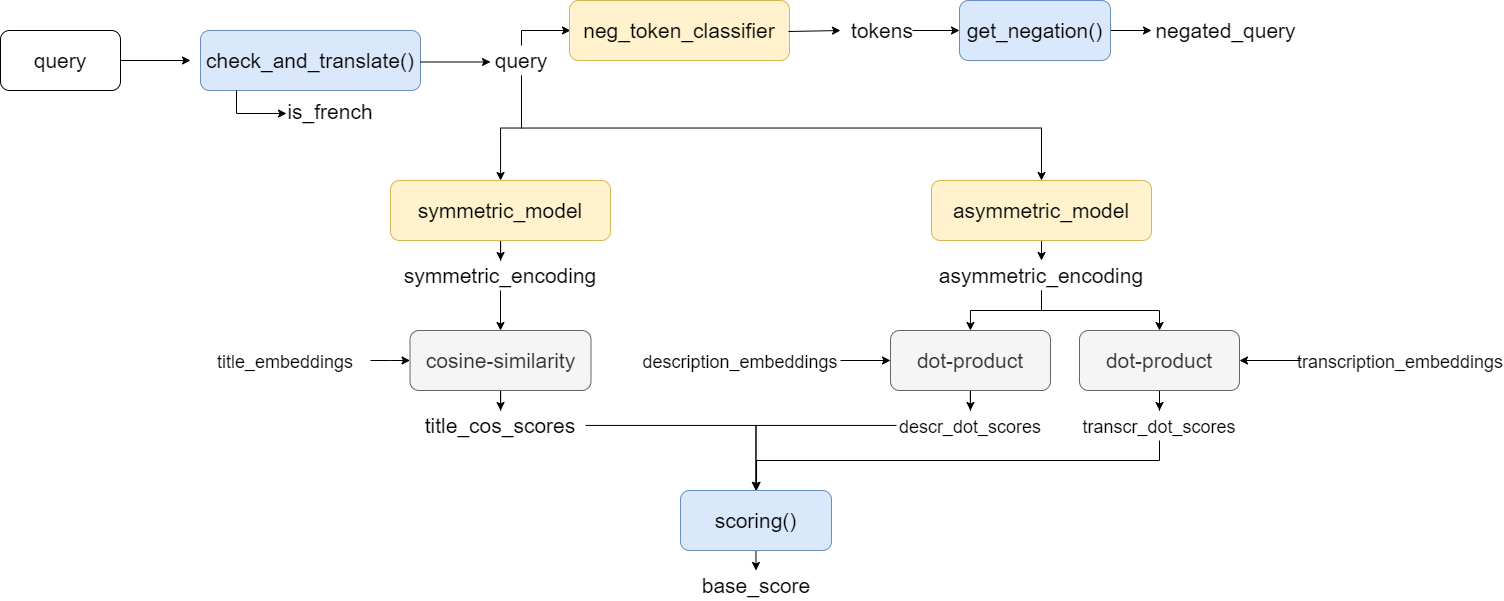

As you can see in the figure above, the query will be passed firts to the `check_and_transate` function where we will retrieve the `is_french` (bool) for later use, and the `query` in english if it wasn't at first.

Then the we will generate a `negated_query` by passing the query through the `neg_token_classifier` and then passing the results (tokens) to the `get_negation()` function. The `negated_query` is a string with all of the negated tokens.
</br></br>
Then we will encode the query with both of the models the symmetric and the asymmetric. Next we will output `title_cos_scores`, `descr_dot_scores` and `transcr_dot_scores`.
</br></br>
The `title_cos_scores` is a score based on cosine-similarity between the `symmetric_encoding` and the `title_embeddings`, while `descr_dot_scores` and the `transcr_dot_scores` are scores based on the dot-product. The first is between the `asymmetric_encoding` and the description_embeddings while the second is between the `asymmetric_encoding` and the `transcription_embeddings`.
</br></br>
Finally, we use the `scoring()` function to get the `base_score` which is calculated as follows:

```
base_score = 0.25 * title_scores_scaled + 0.35 * description_scores_scaled + 0.35 * transcription_scores_scaled
```
2 points to clear here:


* the sum of the coefficents is 0.95 because we will add the popularity score as the last 0.5
* all of the scores were scaled with MinMaxScaler

</br></br>
The figure below explains the 2nd step:

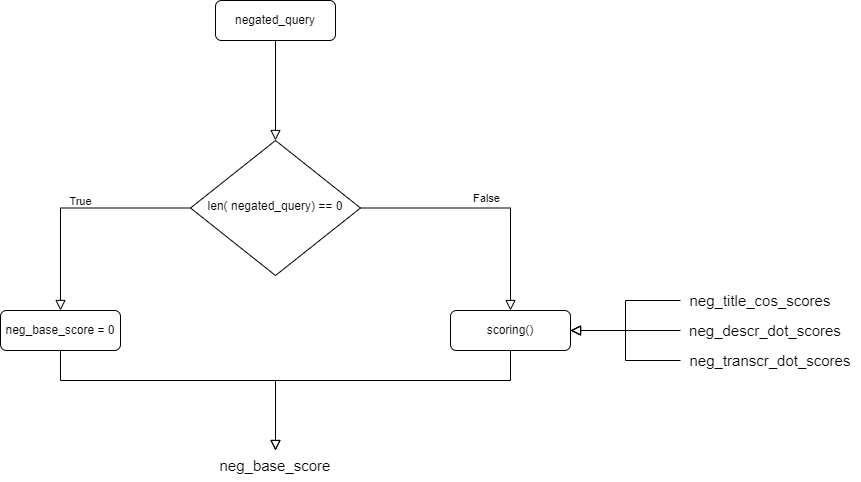

As you can see we retrieve the negated_query and we check whether it is empty or not.
* Empty: `neg_base_score` will receive 0
* Not empty: we will apply the same process that we have done to the normal query, but this time to the negated_query. This process will end with the calling of the `scoring()` function which will get us the `neg_base_score`.



After getting both of the scores `base_score` and `neg_base_score`, we pass to 3rd and last step which is illustrated in the figure below

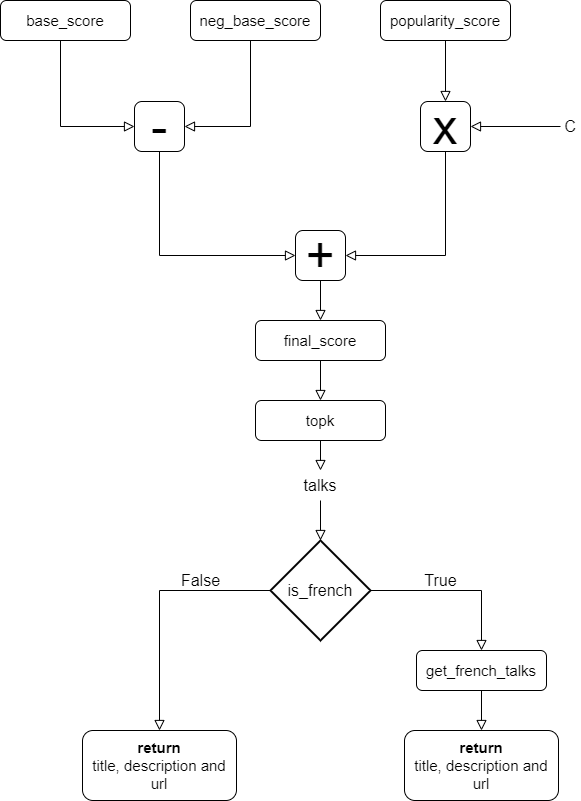

We will first calculate the `final_score` as follows:


```
final_score = base_score - neg_base_score + C * popularity_score
```
Some points need to be clarified:
* the `C` constant here in our case is the 0.05 missing from the base scores calculation
* The popularity score is basically a MinMaxScaler over the views of the talks

After getting the final_score, we use `torch.topk` to get the indices of the `top_n` talks (`top_n` is given by the user with a default value of 5) and use them to retrieve the `talks`.
Then we check if the query was originally in french: 
* if it was in french: we will call the `get_french_talks()` which will try to find the talks in the french dataset by id if they were'nt there it will return the talks from the english dataset translated in french and will finally return the `title`, `description` and `url` of each talk
* if it wasn't in french: it will simply return the `title`, `description` and `url` of each talk

# The Recommendation System

## Some minor preprocessing

In [31]:
df

,talk_id,title,speaker_1,all_speakers,occupations,about_speakers,views,recorded_date,published_date,event,native_lang,available_lang,comments,duration,topics,related_talks,url,description,transcript
0,1,Averting the climate crisis,Al Gore,{0: 'Al Gore'},{0: ['climate advocate']},{0: 'Nobel Laureate Al Gore focused the world’...,3523392,2006-02-25,2006-06-27,TED2006,en,"['ar', 'bg', 'cs', 'de', 'el', 'en', 'es', 'fa...",272.0,977,"['alternative energy', 'cars', 'climate change...","{243: 'New thinking on the climate crisis', 54...",https://www.ted.com/talks/al_gore_averting_the...,With the same humor and humanity he exuded in ...,"Thank you so much, Chris. And it's truly a gre..."
1,92,The best stats you've ever seen,Hans Rosling,{0: 'Hans Rosling'},{0: ['global health expert; data visionary']},"{0: 'In Hans Rosling’s hands, data sings. Glob...",14501685,2006-02-22,2006-06-27,TED2006,en,"['ar', 'az', 'bg', 'bn', 'bs', 'cs', 'da', 'de...",628.0,1190,"['Africa', 'Asia', 'Google', 'demo', 'economic...","{2056: ""Own your body's data"", 2296: 'A visual...",https://www.ted.com/talks/hans_rosling_the_bes...,You've never seen data presented like this. Wi...,"About 10 years ago, I took on the task to teac..."
2,7,Simplicity sells,David Pogue,{0: 'David Pogue'},{0: ['technology columnist']},{0: 'David Pogue is the personal technology co...,1920832,2006-02-24,2006-06-27,TED2006,en,"['ar', 'bg', 'de', 'el', 'en', 'es', 'fa', 'fr...",124.0,1286,"['computers', 'entertainment', 'interface desi...","{1725: '10 top time-saving tech tips', 2274: '...",https://www.ted.com/talks/david_pogue_simplici...,New York Times columnist David Pogue takes aim...,"(Music: ""The Sound of Silence,"" Simon & Garfun..."
3,53,Greening the ghetto,Majora Carter,{0: 'Majora Carter'},{0: ['activist for environmental justice']},{0: 'Majora Carter redefined the field of envi...,2664069,2006-02-26,2006-06-27,TED2006,en,"['ar', 'bg', 'bn', 'ca', 'cs', 'de', 'en', 'es...",219.0,1116,"['MacArthur grant', 'activism', 'business', 'c...",{1041: '3 stories of local eco-entrepreneurshi...,https://www.ted.com/talks/majora_carter_greeni...,"In an emotionally charged talk, MacArthur-winn...",If you're here today — and I'm very happy that...
4,66,Do schools kill creativity?,Sir Ken Robinson,{0: 'Sir Ken Robinson'},"{0: ['author', 'educator']}","{0: ""Creativity expert Sir Ken Robinson challe...",65051954,2006-02-25,2006-06-27,TED2006,en,"['af', 'ar', 'az', 'be', 'bg', 'bn', 'ca', 'cs...",4931.0,1164,"['children', 'creativity', 'culture', 'dance',...","{865: 'Bring on the learning revolution!', 173...",https://www.ted.com/talks/sir_ken_robinson_do_...,Sir Ken Robinson makes an entertaining and pro...,Good morning. How are you? (Audience) Good. It...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3191,24428,Can you solve the fake coin riddle? - Jennifer Lu,Jennifer Lu,{0: 'Jennifer Lu'},NaN,NaN,6218710,2017-01-03,2019-02-22,TED-Ed,en,"['ar', 'bg', 'el', 'es', 'fa', 'fr', 'he', 'hr...",NaN,254,"['creativity', 'TED-Ed', 'animation', 'math', ...","{24416: 'Can you solve the airplane riddle?', ...",https://www.ted.com/talks/jennifer_lu_can_you_...,See the full lesson: http://ed.ted.com/lessons...,"You are the best mathematician in the kingdom,..."
3208,24424,Why are airlines selling too many tickets? - N...,Nina Klietsch,{0: 'Nina Klietsch'},NaN,NaN,2009336,2016-12-20,2019-03-01,TED-Ed,en,"['ar', 'de', 'el', 'es', 'fr', 'he', 'id', 'it...",NaN,284,"['business', 'design', 'technology', 'money', ...",{23762: 'Why do competitors open their stores ...,https://www.ted.com/talks/nina_klietsch_why_do...,Watch the full lesson at ed.ted.com: http://ed...,Have you ever waited hours at the doctor when ...
3267,24432,How do animals feel pain? - Robyn J. Crook,Robyn Crook,{0: 'Robyn Crook'},NaN,NaN,2787054,2017-01-17,2019-03-15,TED-Ed,en,"['ar', 'de', 'el', 'es', 'fa', 'fr', 'he', 'hi...",NaN,286,"['consciousness', 'pain', 'animals', 'science'...",{24463: 'Why do anim

In [32]:
df.isnull().sum()

talk_id             0
title               0
speaker_1           0
all_speakers        4
occupations       525
about_speakers    506
views               0
recorded_date       1
published_date      0
event               0
native_lang         0
available_lang      0
comments          659
duration            0
topics              0
related_talks       0
url                 0
description         0
transcript          0
dtype: int64

In [33]:
# Let's get rid of the columns that have null values since they are not as relevent as the other ones
df.dropna(axis=1, inplace=True)

# Let's recheck
df.isnull().sum()

talk_id           0
title             0
speaker_1         0
views             0
published_date    0
event             0
native_lang       0
available_lang    0
duration          0
topics            0
related_talks     0
url               0
description       0
transcript        0
dtype: int64

## Building the recommendation system

In [34]:
# First we will get the models from SentenceTransformer
symmetric_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
asymmetric_model = SentenceTransformer('msmarco-distilbert-base-dot-prod-v3')

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/115 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.35k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/554 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/265M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/376 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/341 [00:00<?, ?B/s]

In [35]:
# We will also get the negation_bert from hugging face
model_checkpoint = "shoubhikc/negation_bert"
neg_token_classifier = pipeline(
    "token-classification", model=model_checkpoint, aggregation_strategy="simple"
)

Downloading:   0%|          | 0.00/905 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/400 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [36]:
title_list = list(df['title'])
description_list = list(df['description'])
transcription_list = list(df['transcript'])

popularity_array = df['views'].values # This array will be used to calculate score_popularity

#Now we use the lists above to and the models to generate the embeddings

title_embeddings = symmetric_model.encode(title_list)
description_embeddings = asymmetric_model.encode(description_list)
transcription_embeddings = asymmetric_model.encode(transcription_list)

In [37]:
popularity_array = df['views'].values

In [38]:
def recommend(query: str, top_n: Optional[int] = 5):
  """ Takes a query in French or English as an input along with the desired number of ted talks to recommend
    and returns the talks while respecting the language of the query

  Args:
    query: str, can be in English or French
    top_n: Optional[int] default = 5, it is the number of ted talks recommendation desired

  Returns:
    pandas DataFrame consisted of ['title', 'description', 'url'] with the top_n talks

  """
  def check_and_translate(query: str) -> Tuple[bool, str]:
    translator = Translator()
    if translator.detect(query).lang == 'fr':
      query = translator.translate(query, dest='en').text
      return (True, query)
    return (False, query)

  def get_negation(tokens: List) -> str:
    negated_tokens = []
    normal_tokens = []
    if len(tokens)>1:
      for i in range(len(tokens)):
        token = tokens[i]
        if token['entity_group'] == 'LABEL_1' and i < len(tokens) + 1:
          negated_tokens.append(tokens[i+1]['word'])
    neg_query = ' '.join(negated_tokens)
    return neg_query

  def scoring(title_scores: Array, description_scores: Array, transcription_scores: Array) -> Array:
    scaler = MinMaxScaler()
    description_scores_scaled = scaler.fit_transform(description_scores.reshape(-1, 1))
    transcription_scores_scaled = scaler.fit_transform(transcription_scores.reshape(-1, 1))
    title_scores_scaled = scaler.fit_transform(title_scores.reshape(-1, 1))
    score = 0.25 * title_scores_scaled + 0.35 * description_scores_scaled + 0.35 * transcription_scores_scaled
    return score

  def popularity_score(popularity: List) -> Array:
    scaler = MinMaxScaler()
    return scaler.fit_transform(popularity.reshape(-1, 1))

  def get_french_talks(talks: pd.DataFrame) -> pd.DataFrame:
    translator = Translator()
    talks_fr = pd.DataFrame(columns=talks.columns)
    for id in list(talks['talk_id']):
      if len(df_fr[df_fr['talk_id']==id]):
        talks_fr = talks_fr.append(df_fr[df_fr['talk_id']==id])
      else:
        talk = df[df['talk_id']==id]
        talk['title'] = translator.translate(talk['title'], dest='fr').text
        talks_fr = talks_fr.append(talk)
    return talks_fr

  is_french, query = check_and_translate(query)

  tokens = neg_token_classifier(query)
  negated_query = get_negation(tokens)

  symmetric_encoding = symmetric_model.encode(query)
  asymmetric_encoding = asymmetric_model.encode(query)

  title_cos_scores = util.cos_sim(symmetric_encoding, title_embeddings)[0]
  descr_dot_scores = util.dot_score(asymmetric_encoding, description_embeddings)[0]
  transcr_dot_scores = util.dot_score(asymmetric_encoding, transcription_embeddings)[0]

  base_score = scoring(title_cos_scores, descr_dot_scores, transcr_dot_scores)

  if len(negated_query):
    neg_symmetric_encoding = symmetric_model.encode(negated_query)
    neg_asymmetric_encoding = asymmetric_model.encode(negated_query)
    neg_title_cos_scores = util.cos_sim(neg_symmetric_encoding, title_embeddings)[0]
    neg_descr_dot_scores = util.dot_score(neg_asymmetric_encoding, description_embeddings)[0]
    neg_transcr_dot_scores = util.dot_score(neg_asymmetric_encoding, transcription_embeddings)[0]
    neg_base_score = scoring(neg_title_cos_scores, neg_descr_dot_scores, neg_transcr_dot_scores)
  else:
    neg_base_score = 0
  
  final_score = torch.t(torch.from_numpy(base_score - neg_base_score + 0.05 * popularity_score(popularity_array)))
  top_results = torch.topk(final_score[0], k=top_n)

  talks_indices = np.array(top_results.indices)
  talks = df.iloc[talks_indices]
  if is_french:
    return get_french_talks(talks)[['title', 'description', 'url']]

  return talks[['title', 'description', 'url']]

  
    
  

# Demo

In [39]:
recommend('A talk not about climate change')

,title,description,url
2088,10 ways to have a better conversation,When your job hinges on how well you talk to p...,https://www.ted.com/talks/celeste_headlee_10_w...
2135,TED's secret to great public speaking,"There's no single formula for a great talk, bu...",https://www.ted.com/talks/chris_anderson_ted_s...
3941,Why it's so hard to talk about the N-word,Historian Elizabeth Stordeur Pryor leads a tho...,https://www.ted.com/talks/elizabeth_stordeur_p...
871,Remaking my voice,When film critic Roger Ebert lost his lower ja...,https://www.ted.com/talks/roger_ebert_remaking...
1056,"1,000 TED Talks in six words",Sebastian Wernicke thinks every TED Talk can b...,https://www.ted.com/talks/sebastian_wernicke_1...


In [40]:
recommend('Une présentation optimiste sur l’avenir')

,title,description,url
2417,Pourquoi avons-nous besoin d'imaginer des futu...,"Anab Jain rend le futur réel et bien vivant, e...",https://www.ted.com/talks/anab_jain_why_we_nee...
3846,"Allez-y, rêvez de l'avenir",« On ne prédit pas l'avenir – on ne fait que l...,https://www.ted.com/talks/charlie_jane_anders_...
2110,Une vision futuriste de l'Age des hologrammes,Explorez un monde imaginaire digital sans écra...,https://www.ted.com/talks/alex_kipman_a_futuri...
1177,Tali Sharot : Le parti-pris de l'optimisme,Sommes-nous nés optimistes plutôt que réaliste...,https://www.ted.com/talks/tali_sharot_the_opti...
2086,En défense de l'optimisme à propos du changeme...,Al Gore a trois questions à propos du changeme...,https://www.ted.com/talks/al_gore_the_case_for...


In [41]:
# Let's see how well is the negation handling
# First let's see the talks about AI

recommend('A talk about AI', 10)

,title,description,url
3476,How AI could become an extension of your mind,Try talking to yourself without opening your m...,https://www.ted.com/talks/arnav_kapur_how_ai_c...
2896,How AI can save our humanity,"AI is massively transforming our world, but th...",https://www.ted.com/talks/kai_fu_lee_how_ai_ca...
2238,Can we build AI without losing control over it?,"Scared of superintelligent AI? You should be, ...",https://www.ted.com/talks/sam_harris_can_we_bu...
3689,The danger of AI is weirder than you think,The danger of artificial intelligence isn't th...,https://www.ted.com/talks/janelle_shane_the_da...
2291,How AI can bring on a second Industrial Revolu...,"""The actual path of a raindrop as it goes down...",https://www.ted.com/talks/kevin_kelly_how_ai_c...
2667,"How we can build AI to help humans, not hurt us","As a research scientist at Google, Margaret Mi...",https://www.ted.com/talks/margaret_mitchell_ho...
2588,What AI is -- and isn't,Educator and entrepreneur Sebastian Thrun want...,https://www.ted.com/talks/sebastian_thrun_and_...
3840,How humans and AI can work together to create ...,Here's a paradox: as companies try to streamli...,https://www.ted.com/talks/sylvain_duranton_how...
2448,"How AI can enhance our memory, work and social...",How smart can our machines make us? Tom Gruber...,https://www.ted.com/talks/tom_gruber_how_ai_ca...
2396,3 principles for creating safer AI,How can we harness the power of superintellige...,https://www.ted.com/talks/stuart_russell_3_pri...


In [42]:
# Let's see now the effect of adding "without humans" for example

recommend('A talk about AI without humans', 10)

,title,description,url
2238,Can we build AI without losing control over it?,"Scared of superintelligent AI? You should be, ...",https://www.ted.com/talks/sam_harris_can_we_bu...
2588,What AI is -- and isn't,Educator and entrepreneur Sebastian Thrun want...,https://www.ted.com/talks/sebastian_thrun_and_...
2291,How AI can bring on a second Industrial Revolu...,"""The actual path of a raindrop as it goes down...",https://www.ted.com/talks/kevin_kelly_how_ai_c...
3689,The danger of AI is weirder than you think,The danger of artificial intelligence isn't th...,https://www.ted.com/talks/janelle_shane_the_da...
1056,"1,000 TED Talks in six words",Sebastian Wernicke thinks every TED Talk can b...,https://www.ted.com/talks/sebastian_wernicke_1...
3149,How do we learn to work with intelligent machi...,The path to skill around the globe has been th...,https://www.ted.com/talks/matt_beane_how_do_we...
1070,The beautiful math behind the world's ugliest ...,Scott Rickard set out to engineer the ugliest ...,https://www.ted.com/talks/scott_rickard_the_be...
2253,Machine intelligence makes human morals more i...,"Machine intelligence is here, and we're alread...",https://www.ted.com/talks/zeynep_tufekci_machi...
1009,High-tech art (with a sense of humor),Artist and TED Fellow Aparna Rao re-imagines t...,https://www.ted.com/talks/aparna_rao_high_tech...
1168,A 40-year plan for energy,"In this intimate talk filmed at TED's offices,...",https://www.ted.com/talks/amory_lovins_a_40_ye...


In [43]:
# Our engine can also work in the cas of multiple negation

recommend('A talk about AI without humans and without danger', 10)

,title,description,url
3149,How do we learn to work with intelligent machi...,The path to skill around the globe has been th...,https://www.ted.com/talks/matt_beane_how_do_we...
2291,How AI can bring on a second Industrial Revolu...,"""The actual path of a raindrop as it goes down...",https://www.ted.com/talks/kevin_kelly_how_ai_c...
2935,How AI could compose a personalized soundtrack...,"Meet AIVA, an artificial intelligence that has...",https://www.ted.com/talks/pierre_barreau_how_a...
2588,What AI is -- and isn't,Educator and entrepreneur Sebastian Thrun want...,https://www.ted.com/talks/sebastian_thrun_and_...
3476,How AI could become an extension of your mind,Try talking to yourself without opening your m...,https://www.ted.com/talks/arnav_kapur_how_ai_c...
2896,How AI can save our humanity,"AI is massively transforming our world, but th...",https://www.ted.com/talks/kai_fu_lee_how_ai_ca...
1882,Play this word game to come up with original i...,Shimpei Takahashi always dreamed of designing ...,https://www.ted.com/talks/shimpei_takahashi_pl...
1009,High-tech art (with a sense of humor),Artist and TED Fellow Aparna Rao re-imagines t...,https://www.ted.com/talks/aparna_rao_high_tech...
1643,A word game to communicate in any language,While working with kids who have trouble speak...,https://www.ted.com/talks/ajit_narayanan_a_wor...
2270,Easy DIY projects for kid engineers,"TED Resident Fawn Qiu designs fun, low-cost pr...",https://www.ted.com/talks/fawn_qiu_easy_diy_pr...


# Conclusion

As you can see we have successfully managed to build a Recommendation/Search Engine for the TED Talks. The engine works well and the negation effect is handled to some extent. 

We could use other approaches for the problem. For instance, fine-tuning a sentence transformer on the data of the related talks seems like a good idea to try. Of course we will need to build a dataset with pairs of descriptions that belong to related talks.

We can also try to play with the topics for example we can try to predict them use that prediction with semantic search or for score calculation.

One other idea is to use [KeyBERT](https://github.com/MaartenGr/KeyBERT) to extract keywords and use them for search and see if it adds value.